Processing 369 patients...


100%|██████████| 369/369 [13:45<00:00,  2.24s/it]


Successfully extracted features for 369 patients
Performing feature selection...
Selected 30 most important features
Optimizing SVM hyperparameters...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Test Accuracy: 0.9324
Confusion Matrix:
[[12  3]
 [ 2 57]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        15
           1       0.95      0.97      0.96        59

    accuracy                           0.93        74
   macro avg       0.90      0.88      0.89        74
weighted avg       0.93      0.93      0.93        74


Testing model on patient: BraTS20_Training_083
Patient 83 - Prediction: HGG (Probability of HGG: 0.9360)
Actual: HGG - Prediction correct

Model training complete! Results saved to results


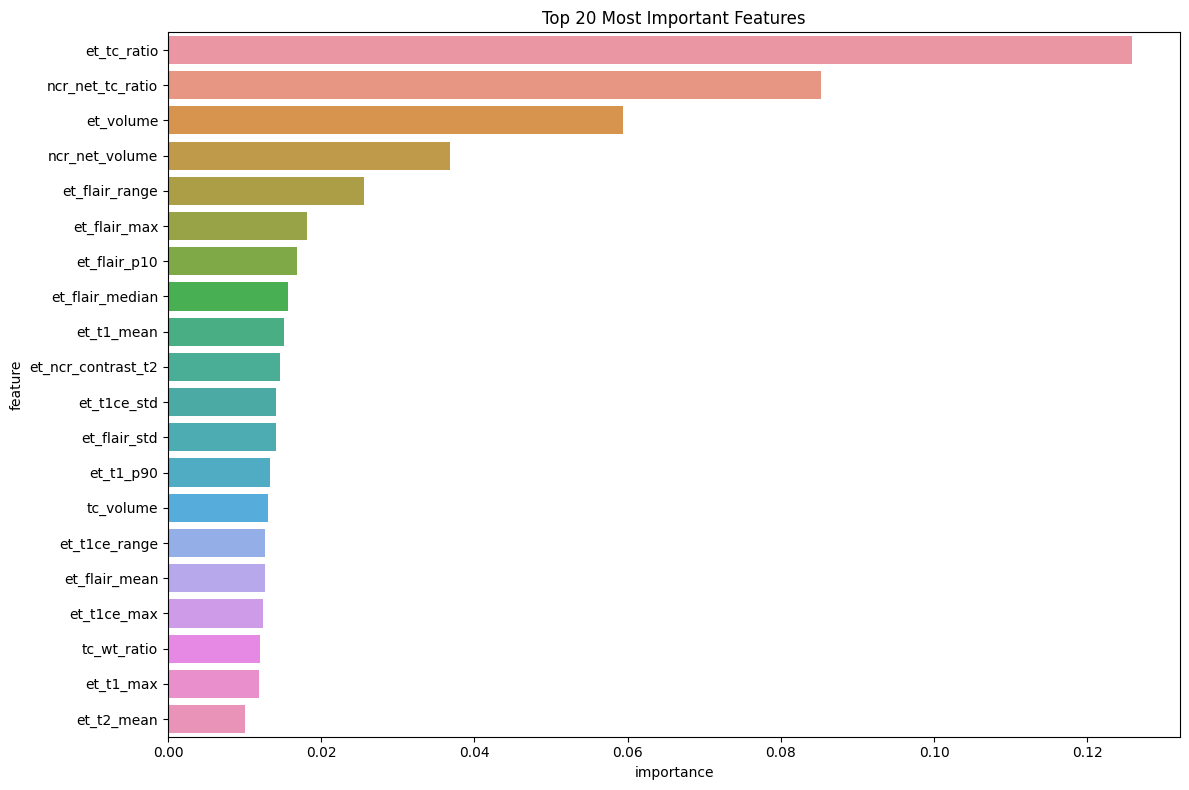

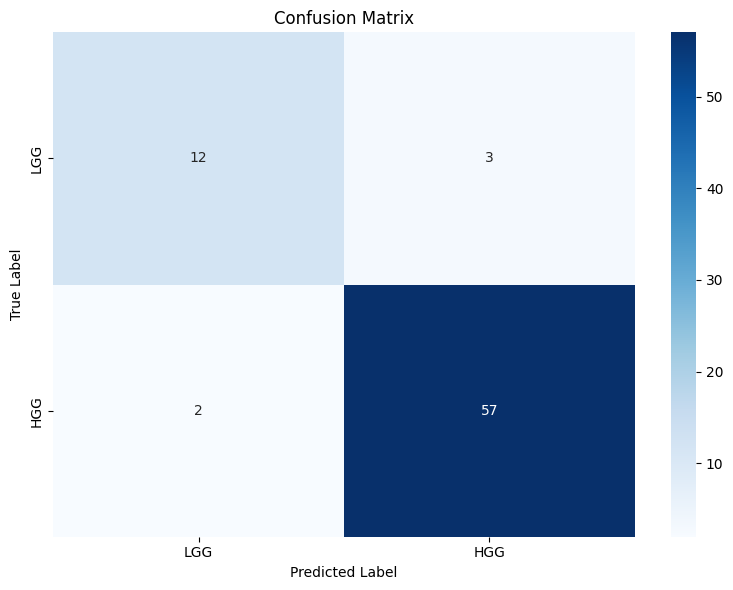

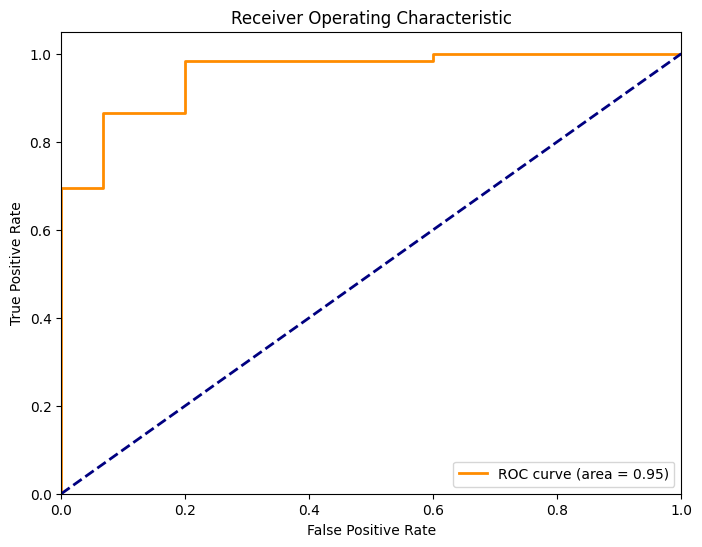

In [1]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import seaborn as sns
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')

# Define paths
DATA_ROOT = '/kaggle/input/brats2020withcorrectnameof355seg/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
MAPPING_PATH = os.path.join(DATA_ROOT, 'name_mapping.csv')
OUTPUT_DIR = 'results'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load mapping file
mapping_df = pd.read_csv(MAPPING_PATH)

def get_patient_label(patient_id):
    """Get binary label (0=LGG, 1=HGG) for a patient ID"""
    pid_str = f'BraTS20_Training_{int(patient_id):03d}'
    match = mapping_df[mapping_df['BraTS_2020_subject_ID'] == pid_str]
    if match.empty:
        raise ValueError(f"Patient {patient_id} not found in mapping")
    return 0 if match.iloc[0]['Grade'].upper() == "LGG" else 1

def extract_features(patient_folder):
    """
    Extract features from segmented tumor images
    
    Features include:
    - Volume features for different tumor components
    - Intensity statistics for each modality within tumor components
    - Texture features based on histogram of oriented gradients
    - Shape-based features
    """
    features = {}
    
    # Get all the segmentation and modality files
    seg_path = os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_seg.nii")
    t1_path = os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_t1.nii")
    t1ce_path = os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_t1ce.nii")
    t2_path = os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_t2.nii")
    flair_path = os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_flair.nii")
    
    # Load segmentation mask and modalities
    seg = nib.load(seg_path).get_fdata()
    t1 = nib.load(t1_path).get_fdata()
    t1ce = nib.load(t1ce_path).get_fdata()
    t2 = nib.load(t2_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()
    
    # Define tumor components
    # Label 1: Necrotic and non-enhancing tumor core (NCR/NET)
    # Label 2: Peritumoral edema (ED)
    # Label 4: GD-enhancing tumor (ET)
    # Tumor core (TC): Label 1 + Label 4
    # Whole tumor (WT): Label 1 + Label 2 + Label 4
    
    # Create masks for different tumor components
    ncr_net_mask = (seg == 1)
    ed_mask = (seg == 2)
    et_mask = (seg == 4)
    tc_mask = ncr_net_mask | et_mask
    wt_mask = ncr_net_mask | ed_mask | et_mask
    
    # 1. Volume features
    voxel_volume = 1.0  # Voxel volume in mm³ (assuming isotropic 1mm voxels)
    features['ncr_net_volume'] = np.sum(ncr_net_mask) * voxel_volume
    features['ed_volume'] = np.sum(ed_mask) * voxel_volume
    features['et_volume'] = np.sum(et_mask) * voxel_volume
    features['tc_volume'] = np.sum(tc_mask) * voxel_volume
    features['wt_volume'] = np.sum(wt_mask) * voxel_volume
    
    # Volume ratios
    if features['wt_volume'] > 0:
        features['tc_wt_ratio'] = features['tc_volume'] / features['wt_volume']
        features['et_tc_ratio'] = features['et_volume'] / features['tc_volume'] if features['tc_volume'] > 0 else 0
        features['ncr_net_tc_ratio'] = features['ncr_net_volume'] / features['tc_volume'] if features['tc_volume'] > 0 else 0
        features['ed_wt_ratio'] = features['ed_volume'] / features['wt_volume']
    else:
        features['tc_wt_ratio'] = 0
        features['et_tc_ratio'] = 0
        features['ncr_net_tc_ratio'] = 0
        features['ed_wt_ratio'] = 0
    
    # 2. Intensity statistics for each modality within tumor regions
    for mask_name, mask in [('wt', wt_mask), ('tc', tc_mask), ('et', et_mask), ('ed', ed_mask), ('ncr_net', ncr_net_mask)]:
        for modality_name, modality in [('t1', t1), ('t1ce', t1ce), ('t2', t2), ('flair', flair)]:
            if np.sum(mask) > 0:
                modality_values = modality[mask]
                features[f'{mask_name}_{modality_name}_mean'] = np.mean(modality_values)
                features[f'{mask_name}_{modality_name}_std'] = np.std(modality_values)
                features[f'{mask_name}_{modality_name}_min'] = np.min(modality_values)
                features[f'{mask_name}_{modality_name}_max'] = np.max(modality_values)
                features[f'{mask_name}_{modality_name}_median'] = np.median(modality_values)
                features[f'{mask_name}_{modality_name}_p10'] = np.percentile(modality_values, 10)
                features[f'{mask_name}_{modality_name}_p90'] = np.percentile(modality_values, 90)
                features[f'{mask_name}_{modality_name}_range'] = features[f'{mask_name}_{modality_name}_max'] - features[f'{mask_name}_{modality_name}_min']
            else:
                features[f'{mask_name}_{modality_name}_mean'] = 0
                features[f'{mask_name}_{modality_name}_std'] = 0
                features[f'{mask_name}_{modality_name}_min'] = 0
                features[f'{mask_name}_{modality_name}_max'] = 0
                features[f'{mask_name}_{modality_name}_median'] = 0
                features[f'{mask_name}_{modality_name}_p10'] = 0
                features[f'{mask_name}_{modality_name}_p90'] = 0
                features[f'{mask_name}_{modality_name}_range'] = 0
    
    # 3. Shape features
    if np.sum(wt_mask) > 0:
        # Calculate axes lengths
        z_proj = np.sum(wt_mask, axis=(0, 1))
        y_proj = np.sum(wt_mask, axis=(0, 2))
        x_proj = np.sum(wt_mask, axis=(1, 2))
        
        features['wt_z_extent'] = np.sum(z_proj > 0)
        features['wt_y_extent'] = np.sum(y_proj > 0)
        features['wt_x_extent'] = np.sum(x_proj > 0)
        
        # Sphericity approximation (using major and minor axes)
        axes = sorted([features['wt_x_extent'], features['wt_y_extent'], features['wt_z_extent']])
        features['wt_elongation'] = axes[2] / axes[0] if axes[0] > 0 else 0
        features['wt_flatness'] = axes[1] / axes[0] if axes[0] > 0 else 0
        
        # Sphericity approximation
        surface_area_approx = 4 * np.pi * ((axes[0] * axes[1] * axes[2] / 8) ** (2/3))
        volume = features['wt_volume']
        perfect_sphere_surface = (36 * np.pi * (volume ** 2)) ** (1/3)
        features['wt_sphericity'] = perfect_sphere_surface / surface_area_approx if surface_area_approx > 0 else 0
    else:
        features['wt_z_extent'] = 0
        features['wt_y_extent'] = 0
        features['wt_x_extent'] = 0
        features['wt_elongation'] = 0
        features['wt_flatness'] = 0
        features['wt_sphericity'] = 0
    
    # 4. Heterogeneity features
    # Calculate contrast between tumor components for each modality
    for modality_name, modality in [('t1', t1), ('t1ce', t1ce), ('t2', t2), ('flair', flair)]:
        # Contrast between tumor core and edema
        if np.sum(tc_mask) > 0 and np.sum(ed_mask) > 0:
            tc_mean = np.mean(modality[tc_mask])
            ed_mean = np.mean(modality[ed_mask])
            features[f'tc_ed_contrast_{modality_name}'] = abs(tc_mean - ed_mean)
        else:
            features[f'tc_ed_contrast_{modality_name}'] = 0
            
        # Contrast between enhancing tumor and necrotic core
        if np.sum(et_mask) > 0 and np.sum(ncr_net_mask) > 0:
            et_mean = np.mean(modality[et_mask])
            ncr_mean = np.mean(modality[ncr_net_mask])
            features[f'et_ncr_contrast_{modality_name}'] = abs(et_mean - ncr_mean)
        else:
            features[f'et_ncr_contrast_{modality_name}'] = 0
    
    return features

def load_data():
    """
    Load all patient data and extract features
    Returns DataFrame with features and labels
    """
    # Get list of patient folders
    patient_folders = [os.path.join(DATA_ROOT, f) for f in os.listdir(DATA_ROOT) 
                      if os.path.isdir(os.path.join(DATA_ROOT, f)) and f.startswith('BraTS20_Training_')]
    
    all_features = []
    patient_ids = []
    
    print(f"Processing {len(patient_folders)} patients...")
    for folder in tqdm(patient_folders):
        patient_id = int(os.path.basename(folder).split('_')[-1])
        try:
            features = extract_features(folder)
            features['patient_id'] = patient_id
            features['grade'] = get_patient_label(patient_id)
            all_features.append(features)
            patient_ids.append(patient_id)
        except Exception as e:
            print(f"Error processing patient {patient_id}: {e}")
    
    # Convert to DataFrame
    features_df = pd.DataFrame(all_features)
    print(f"Successfully extracted features for {len(features_df)} patients")
    
    return features_df

def train_svm_model(features_df):
    """
    Train SVM model with feature selection and hyperparameter tuning
    """
    # Separate features and target
    X = features_df.drop(['patient_id', 'grade'], axis=1)
    y = features_df['grade']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Feature selection using Random Forest importance
    print("Performing feature selection...")
    selector = RandomForestClassifier(n_estimators=100, random_state=42)
    selector.fit(X_train_scaled, y_train)
    
    # Get feature importances
    importances = pd.DataFrame({
        'feature': X.columns,
        'importance': selector.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Select top features
    top_n_features = 30  # Select top 30 features
    top_features = importances.nlargest(top_n_features, 'importance')['feature'].tolist()
    
    print(f"Selected {len(top_features)} most important features")
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=importances.nlargest(20, 'importance'))
    plt.title('Top 20 Most Important Features')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'feature_importance.png'))
    
    # Use only selected features
    X_train_selected = X_train_scaled[:, [X.columns.get_loc(feature) for feature in top_features]]
    X_test_selected = X_test_scaled[:, [X.columns.get_loc(feature) for feature in top_features]]
    
    # Grid search for SVM hyperparameters
    print("Optimizing SVM hyperparameters...")
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.01, 0.1],
        'kernel': ['rbf', 'linear', 'poly']
    }
    
    svm_grid = GridSearchCV(SVC(probability=True, random_state=42), 
                          param_grid=param_grid, 
                          cv=5, 
                          verbose=1,
                          scoring='accuracy')
    
    svm_grid.fit(X_train_selected, y_train)
    
    # Get best model
    best_svm = svm_grid.best_estimator_
    print(f"Best parameters: {svm_grid.best_params_}")
    
    # Evaluate on test set
    y_pred = best_svm.predict(X_test_selected)
    y_pred_prob = best_svm.predict_proba(X_test_selected)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
               xticklabels=['LGG', 'HGG'], 
               yticklabels=['LGG', 'HGG'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(OUTPUT_DIR, 'roc_curve.png'))
    
    # Save model and related objects
    model_data = {
        'svm_model': best_svm,
        'scaler': scaler,
        'top_features': top_features,
        'feature_importances': importances,
        'metrics': {
            'accuracy': accuracy,
            'confusion_matrix': conf_matrix,
            'classification_report': class_report,
            'roc_auc': roc_auc
        }
    }
    
    with open(os.path.join(OUTPUT_DIR, 'svm_model.pkl'), 'wb') as f:
        pickle.dump(model_data, f)
    
    # Save feature names for future reference
    with open(os.path.join(OUTPUT_DIR, 'top_features.txt'), 'w') as f:
        for feature in top_features:
            f.write(f"{feature}\n")
            
    return model_data

def predict_example(model_data, patient_folder):
    """
    Example prediction function for a new patient
    """
    # Extract patient ID from folder name
    patient_id = int(os.path.basename(patient_folder).split('_')[-1])
    
    # Extract features
    features = extract_features(patient_folder)
    
    # Convert to DataFrame with all features
    features_df = pd.DataFrame([features])
    
    # Apply scaler
    scaler = model_data['scaler']
    X_scaled = scaler.transform(features_df)
    
    # Select top features
    top_features = model_data['top_features']
    top_feature_indices = [features_df.columns.get_loc(feature) for feature in top_features if feature in features_df.columns]
    X_selected = X_scaled[:, top_feature_indices]
    
    # Make prediction
    svm_model = model_data['svm_model']
    prediction = svm_model.predict(X_selected)[0]
    probability = svm_model.predict_proba(X_selected)[0][1]
    
    result = {
        'patient_id': patient_id,
        'prediction': 'HGG' if prediction == 1 else 'LGG',
        'probability': probability
    }
    
    print(f"Patient {patient_id} - Prediction: {result['prediction']} (Probability of HGG: {probability:.4f})")
    
    # Get actual label if available
    try:
        actual_label = get_patient_label(patient_id)
        result['actual_label'] = 'HGG' if actual_label == 1 else 'LGG'
        result['correct'] = (prediction == actual_label)
        print(f"Actual: {result['actual_label']} - Prediction {'correct' if result['correct'] else 'incorrect'}")
    except:
        print("Actual label not available")
    
    return result

if __name__ == "__main__":
    # Load and process all data
    features_df = load_data()
    
    # Save full feature dataset to CSV
    features_df.to_csv(os.path.join(OUTPUT_DIR, 'tumor_features.csv'), index=False)
    
    # Train SVM model
    model_data = train_svm_model(features_df)
    
    # Example: Test the model on a specific patient
    # Get a random test patient
    test_patients = [os.path.join(DATA_ROOT, f) for f in os.listdir(DATA_ROOT) 
                    if os.path.isdir(os.path.join(DATA_ROOT, f)) and f.startswith('BraTS20_Training_')]
    
    if test_patients:
        test_patient = test_patients[0]  # Use first patient as example
        print(f"\nTesting model on patient: {os.path.basename(test_patient)}")
        prediction_result = predict_example(model_data, test_patient)
        
        # Save test results
        with open(os.path.join(OUTPUT_DIR, 'example_test.txt'), 'w') as f:
            for key, value in prediction_result.items():
                f.write(f"{key}: {value}\n")
    
    print(f"\nModel training complete! Results saved to {OUTPUT_DIR}")

Processing patient: BraTS20_Training_015

==== Prediction Results ====
Patient ID: BraTS20_Training_015
Prediction: HGG
Confidence: 93.93% HGG, 6.07% LGG

==== Key Feature Values ====
et_tc_ratio: 0.5092
ncr_net_tc_ratio: 0.4908
et_volume: 9002.0000
ncr_net_volume: 8675.0000
et_flair_range: 909.0000
et_flair_max: 957.0000
et_flair_p10: 325.0000
et_flair_median: 421.5000
et_t1_mean: 359.4868
et_ncr_contrast_t2: 12.8404

Visualization saved as patient_15_prediction.png
Processing patient: BraTS20_Training_123

==== Prediction Results ====
Patient ID: BraTS20_Training_123
Prediction: HGG
Confidence: 97.03% HGG, 2.97% LGG
Actual Label: HGG
Prediction correct

==== Key Feature Values ====
et_tc_ratio: 0.6903
ncr_net_tc_ratio: 0.3097
et_volume: 25719.0000
ncr_net_volume: 11539.0000
et_flair_range: 1061.0000
et_flair_max: 1061.0000
et_flair_p10: 210.0000
et_flair_median: 442.0000
et_t1_mean: 388.3544
et_ncr_contrast_t2: 16.4791

Visualization saved as patient_123_prediction.png
Processing pat

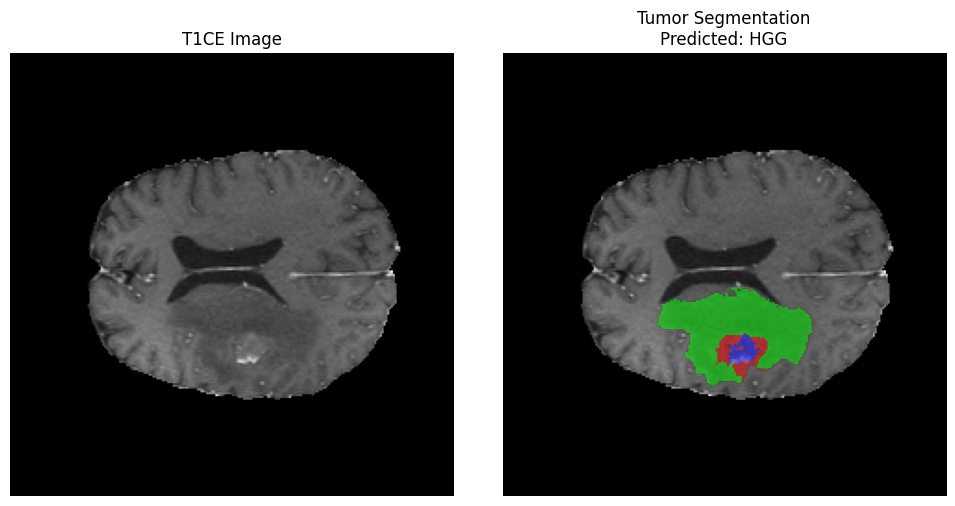

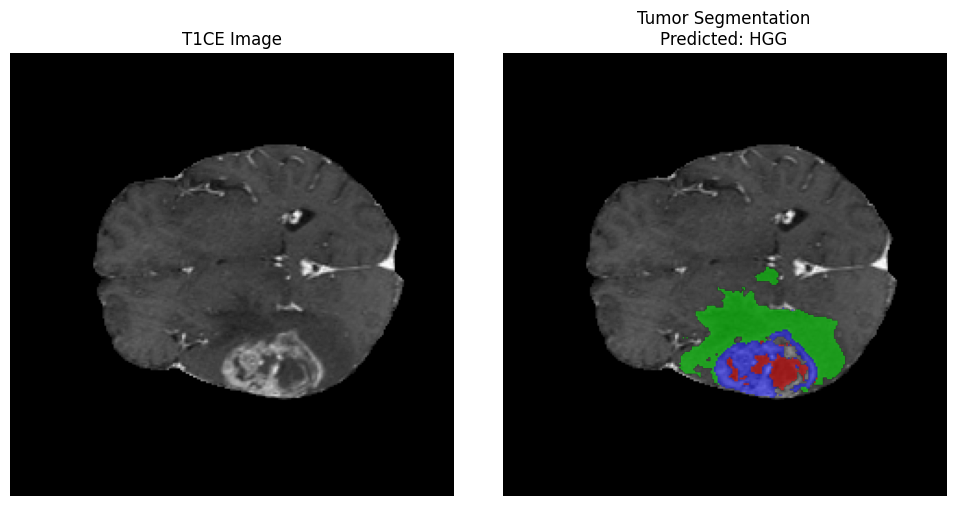

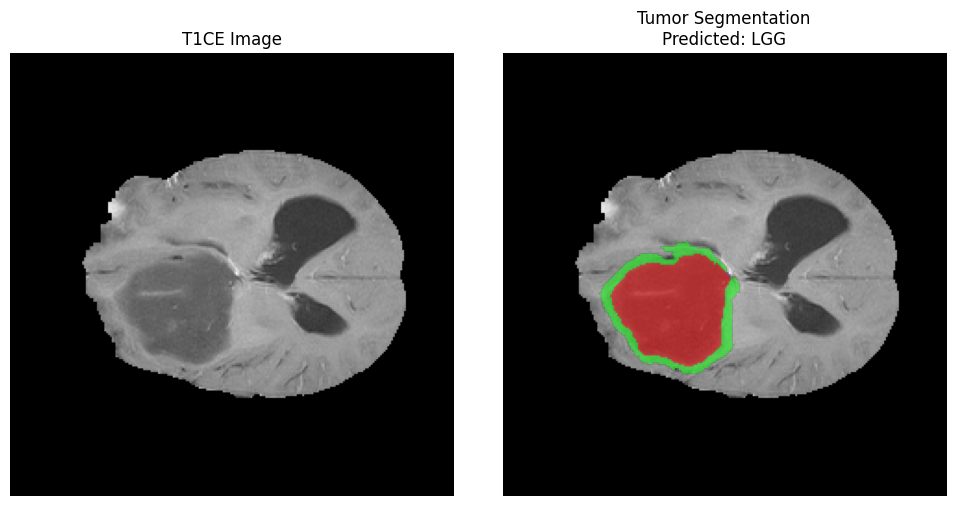

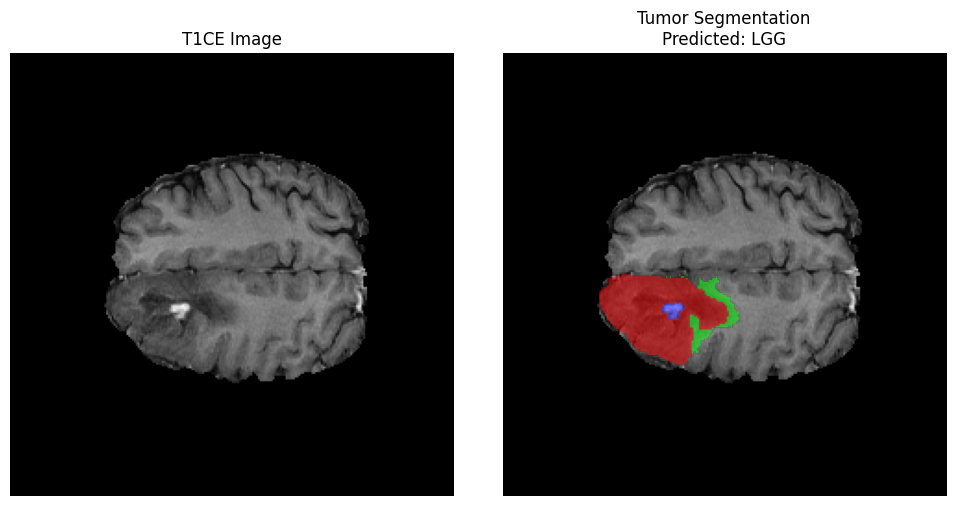

In [4]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings('ignore')

# Define paths
DATA_ROOT = '/kaggle/input/brats2020withcorrectnameof355seg/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
MAPPING_PATH = os.path.join(DATA_ROOT, 'name_mapping.csv')
MODEL_PATH = 'results/svm_model.pkl'

# Load mapping file
mapping_df = pd.read_csv(MAPPING_PATH)

def get_patient_label(patient_id):
    """Get binary label (0=LGG, 1=HGG) for a patient ID"""
    pid_str = f'BraTS20_Training_{patient_id}'
    match = mapping_df[mapping_df['BraTS_2020_subject_ID'] == pid_str]
    if match.empty:
        raise ValueError(f"Patient {patient_id} not found in mapping")
    return 0 if match.iloc[0]['Grade'].upper() == "LGG" else 1

def extract_features(patient_folder):
    """
    Extract features from segmented tumor images
    
    Features include:
    - Volume features for different tumor components
    - Intensity statistics for each modality within tumor components
    - Texture features based on histogram of oriented gradients
    - Shape-based features
    """
    features = {}
    
    # Get all the segmentation and modality files
    seg_path = os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_seg.nii")
    t1_path = os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_t1.nii")
    t1ce_path = os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_t1ce.nii")
    t2_path = os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_t2.nii")
    flair_path = os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_flair.nii")
    
    # Load segmentation mask and modalities
    seg = nib.load(seg_path).get_fdata()
    t1 = nib.load(t1_path).get_fdata()
    t1ce = nib.load(t1ce_path).get_fdata()
    t2 = nib.load(t2_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()
    
    # Define tumor components
    # Label 1: Necrotic and non-enhancing tumor core (NCR/NET)
    # Label 2: Peritumoral edema (ED)
    # Label 4: GD-enhancing tumor (ET)
    # Tumor core (TC): Label 1 + Label 4
    # Whole tumor (WT): Label 1 + Label 2 + Label 4
    
    # Create masks for different tumor components
    ncr_net_mask = (seg == 1)
    ed_mask = (seg == 2)
    et_mask = (seg == 4)
    tc_mask = ncr_net_mask | et_mask
    wt_mask = ncr_net_mask | ed_mask | et_mask
    
    # 1. Volume features
    voxel_volume = 1.0  # Voxel volume in mm³ (assuming isotropic 1mm voxels)
    features['ncr_net_volume'] = np.sum(ncr_net_mask) * voxel_volume
    features['ed_volume'] = np.sum(ed_mask) * voxel_volume
    features['et_volume'] = np.sum(et_mask) * voxel_volume
    features['tc_volume'] = np.sum(tc_mask) * voxel_volume
    features['wt_volume'] = np.sum(wt_mask) * voxel_volume
    
    # Volume ratios
    if features['wt_volume'] > 0:
        features['tc_wt_ratio'] = features['tc_volume'] / features['wt_volume']
        features['et_tc_ratio'] = features['et_volume'] / features['tc_volume'] if features['tc_volume'] > 0 else 0
        features['ncr_net_tc_ratio'] = features['ncr_net_volume'] / features['tc_volume'] if features['tc_volume'] > 0 else 0
        features['ed_wt_ratio'] = features['ed_volume'] / features['wt_volume']
    else:
        features['tc_wt_ratio'] = 0
        features['et_tc_ratio'] = 0
        features['ncr_net_tc_ratio'] = 0
        features['ed_wt_ratio'] = 0
    
    # 2. Intensity statistics for each modality within tumor regions
    for mask_name, mask in [('wt', wt_mask), ('tc', tc_mask), ('et', et_mask), ('ed', ed_mask), ('ncr_net', ncr_net_mask)]:
        for modality_name, modality in [('t1', t1), ('t1ce', t1ce), ('t2', t2), ('flair', flair)]:
            if np.sum(mask) > 0:
                modality_values = modality[mask]
                features[f'{mask_name}_{modality_name}_mean'] = np.mean(modality_values)
                features[f'{mask_name}_{modality_name}_std'] = np.std(modality_values)
                features[f'{mask_name}_{modality_name}_min'] = np.min(modality_values)
                features[f'{mask_name}_{modality_name}_max'] = np.max(modality_values)
                features[f'{mask_name}_{modality_name}_median'] = np.median(modality_values)
                features[f'{mask_name}_{modality_name}_p10'] = np.percentile(modality_values, 10)
                features[f'{mask_name}_{modality_name}_p90'] = np.percentile(modality_values, 90)
                features[f'{mask_name}_{modality_name}_range'] = features[f'{mask_name}_{modality_name}_max'] - features[f'{mask_name}_{modality_name}_min']
            else:
                features[f'{mask_name}_{modality_name}_mean'] = 0
                features[f'{mask_name}_{modality_name}_std'] = 0
                features[f'{mask_name}_{modality_name}_min'] = 0
                features[f'{mask_name}_{modality_name}_max'] = 0
                features[f'{mask_name}_{modality_name}_median'] = 0
                features[f'{mask_name}_{modality_name}_p10'] = 0
                features[f'{mask_name}_{modality_name}_p90'] = 0
                features[f'{mask_name}_{modality_name}_range'] = 0
    
    # 3. Shape features
    if np.sum(wt_mask) > 0:
        # Calculate axes lengths
        z_proj = np.sum(wt_mask, axis=(0, 1))
        y_proj = np.sum(wt_mask, axis=(0, 2))
        x_proj = np.sum(wt_mask, axis=(1, 2))
        
        features['wt_z_extent'] = np.sum(z_proj > 0)
        features['wt_y_extent'] = np.sum(y_proj > 0)
        features['wt_x_extent'] = np.sum(x_proj > 0)
        
        # Sphericity approximation (using major and minor axes)
        axes = sorted([features['wt_x_extent'], features['wt_y_extent'], features['wt_z_extent']])
        features['wt_elongation'] = axes[2] / axes[0] if axes[0] > 0 else 0
        features['wt_flatness'] = axes[1] / axes[0] if axes[0] > 0 else 0
        
        # Sphericity approximation
        surface_area_approx = 4 * np.pi * ((axes[0] * axes[1] * axes[2] / 8) ** (2/3))
        volume = features['wt_volume']
        perfect_sphere_surface = (36 * np.pi * (volume ** 2)) ** (1/3)
        features['wt_sphericity'] = perfect_sphere_surface / surface_area_approx if surface_area_approx > 0 else 0
    else:
        features['wt_z_extent'] = 0
        features['wt_y_extent'] = 0
        features['wt_x_extent'] = 0
        features['wt_elongation'] = 0
        features['wt_flatness'] = 0
        features['wt_sphericity'] = 0
    
    # 4. Heterogeneity features
    # Calculate contrast between tumor components for each modality
    for modality_name, modality in [('t1', t1), ('t1ce', t1ce), ('t2', t2), ('flair', flair)]:
        # Contrast between tumor core and edema
        if np.sum(tc_mask) > 0 and np.sum(ed_mask) > 0:
            tc_mean = np.mean(modality[tc_mask])
            ed_mean = np.mean(modality[ed_mask])
            features[f'tc_ed_contrast_{modality_name}'] = abs(tc_mean - ed_mean)
        else:
            features[f'tc_ed_contrast_{modality_name}'] = 0
            
        # Contrast between enhancing tumor and necrotic core
        if np.sum(et_mask) > 0 and np.sum(ncr_net_mask) > 0:
            et_mean = np.mean(modality[et_mask])
            ncr_mean = np.mean(modality[ncr_net_mask])
            features[f'et_ncr_contrast_{modality_name}'] = abs(et_mean - ncr_mean)
        else:
            features[f'et_ncr_contrast_{modality_name}'] = 0
    
    return features

def predict_patient_grade(patient_id=None):
    """
    Predict tumor grade for a specific patient or a random patient if none is specified
    
    Args:
        patient_id: Integer ID of the patient to predict (e.g., 123 for BraTS20_Training_123)
                   If None, a random patient will be selected
    
    Returns:
        Dictionary containing prediction results
    """
    # Load the trained model
    try:
        with open(MODEL_PATH, 'rb') as f:
            model_data = pickle.load(f)
    except FileNotFoundError:
        print(f"Error: Model file not found at {MODEL_PATH}")
        print("Please ensure you have trained and saved the SVM model first.")
        return None
    
    # Get list of patient folders
    patient_folders = [os.path.join(DATA_ROOT, f) for f in os.listdir(DATA_ROOT) 
                      if os.path.isdir(os.path.join(DATA_ROOT, f)) and f.startswith('BraTS20_Training_')]
    
    # If no patient_id is provided, select a random patient
    if patient_id is None:
        patient_folder = random.choice(patient_folders)
        patient_id = int(os.path.basename(patient_folder).split('_')[-1])
    else:
        patient_folder = os.path.join(DATA_ROOT, f'BraTS20_Training_{patient_id:03d}')
        if not os.path.exists(patient_folder):
            print(f"Error: Patient folder for ID {patient_id} not found.")
            return None
    
    print(f"Processing patient: BraTS20_Training_{patient_id:03d}")
    
    # Extract features
    try:
        features = extract_features(patient_folder)
    except Exception as e:
        print(f"Error extracting features: {e}")
        return None
    
    # Convert to DataFrame
    features_df = pd.DataFrame([features])
    
    # Apply scaler
    scaler = model_data['scaler']
    X_scaled = scaler.transform(features_df)
    
    # Select top features
    top_features = model_data['top_features']
    X_selected = np.zeros((1, len(top_features)))
    
    # Ensure we're using the correct features
    for i, feature in enumerate(top_features):
        if feature in features_df.columns:
            X_selected[0, i] = X_scaled[0, features_df.columns.get_loc(feature)]
        else:
            print(f"Warning: Feature '{feature}' not found in extracted features. Using 0 instead.")
    
    # Make prediction
    svm_model = model_data['svm_model']
    prediction = svm_model.predict(X_selected)[0]
    probabilities = svm_model.predict_proba(X_selected)[0]
    
    # Create result dictionary
    result = {
        'patient_id': patient_id,
        'prediction': 'HGG' if prediction == 1 else 'LGG',
        'probability_HGG': probabilities[1],
        'probability_LGG': probabilities[0]
    }
    
    # Get actual label if available
    try:
        actual_label = get_patient_label(patient_id)
        result['actual_label'] = 'HGG' if actual_label == 1 else 'LGG'
        result['correct'] = (prediction == actual_label)
    except Exception as e:
        print(f"Warning: Could not retrieve actual label: {e}")
        result['actual_label'] = 'Unknown'
        result['correct'] = None
    
    # Print results
    print("\n==== Prediction Results ====")
    print(f"Patient ID: BraTS20_Training_{patient_id:03d}")
    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['probability_HGG']*100:.2f}% HGG, {result['probability_LGG']*100:.2f}% LGG")
    
    if result['actual_label'] != 'Unknown':
        print(f"Actual Label: {result['actual_label']}")
        print(f"Prediction {'correct' if result['correct'] else 'incorrect'}")
        
    # Visualize some key features
    if model_data.get('feature_importances') is not None:
        top_10_features = model_data['feature_importances'].nlargest(10, 'importance')['feature'].tolist()
        
        # Get values for these features
        feature_values = {}
        for feature in top_10_features:
            if feature in features_df.columns:
                feature_values[feature] = features_df[feature].values[0]
        
        print("\n==== Key Feature Values ====")
        for feature, value in feature_values.items():
            print(f"{feature}: {value:.4f}")
    
    # Visualize one slice of the tumor (optional)
    try:
        # Load the segmentation mask
        seg_path = os.path.join(patient_folder, f"BraTS20_Training_{patient_id:03d}_seg.nii")
        seg = nib.load(seg_path).get_fdata()
        
        # Load the T1CE image (usually best for visualizing tumors)
        t1ce_path = os.path.join(patient_folder, f"BraTS20_Training_{patient_id:03d}_t1ce.nii")
        t1ce = nib.load(t1ce_path).get_fdata()
        
        # Find the middle slice with the largest tumor area
        z_sum = np.sum(seg > 0, axis=(0, 1))
        if np.max(z_sum) > 0:
            best_slice = np.argmax(z_sum)
            
            # Create a visualization
            plt.figure(figsize=(10, 5))
            
            # Plot T1CE image
            plt.subplot(1, 2, 1)
            plt.imshow(t1ce[:, :, best_slice], cmap='gray')
            plt.title('T1CE Image')
            plt.axis('off')
            
            # Plot segmentation overlay
            plt.subplot(1, 2, 2)
            plt.imshow(t1ce[:, :, best_slice], cmap='gray')
            
            # Overlay segmentation with different colors for different components
            # Red: Necrotic and non-enhancing tumor core (label 1)
            # Green: Peritumoral edema (label 2)
            # Blue: Enhancing tumor (label 4)
            mask = np.zeros((seg.shape[0], seg.shape[1], 4))
            mask[seg[:, :, best_slice] == 1, 0] = 1  # Red for necrotic core
            mask[seg[:, :, best_slice] == 1, 3] = 0.5  # Alpha
            
            mask[seg[:, :, best_slice] == 2, 1] = 1  # Green for edema
            mask[seg[:, :, best_slice] == 2, 3] = 0.5  # Alpha
            
            mask[seg[:, :, best_slice] == 4, 2] = 1  # Blue for enhancing tumor
            mask[seg[:, :, best_slice] == 4, 3] = 0.5  # Alpha
            
            plt.imshow(mask)
            plt.title(f'Tumor Segmentation\nPredicted: {result["prediction"]}')
            plt.axis('off')
            
            # Save the figure
            plt.tight_layout()
            plt.savefig(f'patient_{patient_id}_prediction.png')
            print(f"\nVisualization saved as patient_{patient_id}_prediction.png")
    except Exception as e:
        print(f"\nCould not generate visualization: {e}")
    
    return result

if __name__ == "__main__":
    # Option 1: Choose a specific patient ID
    # result = predict_patient_grade(patient_id=123)
    
    # Option 2: Let the script choose a random patient
    # result = predict_patient_grade()
    
    # You can also add a loop to test multiple patients
    
    test_patients = [15, 123, 234, 300]
    results = []
    
    for patient_id in test_patients:
        result = predict_patient_grade(patient_id)
        results.append(result)
    
    # Calculate accuracy on this test set
    correct_count = sum(1 for r in results if r['correct'])
    accuracy = correct_count / len(results)
    print(f"\nAccuracy on test set: {accuracy*100:.2f}%")
    

In [1]:
import os
import pickle
import pandas as pd

# 1) where you saved your model
MODEL_PATH = 'results/svm_model.pkl'

# 2) folder of the patient you want to test (change the ID)
DATA_ROOT     = '/kaggle/input/brats2020withcorrectnameof355seg/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
patient_id    = '083'   # e.g. '083'
patient_folder = os.path.join(DATA_ROOT, f'BraTS20_Training_{patient_id}')

# 3) load model_data
with open(MODEL_PATH, 'rb') as f:
    model_data = pickle.load(f)

# 4) extract_features must be defined in your notebook already
#    (the same function you used during training)
features = extract_features(patient_folder)

# 5) turn into DataFrame
df = pd.DataFrame([features])

# 6) scale *all* features, then select the ones your model uses
scaler         = model_data['scaler']
top_features   = model_data['top_features']

X_scaled       = scaler.transform(df.drop(['patient_id','grade'], axis=1))
cols           = list(df.drop(['patient_id','grade'], axis=1).columns)
selected_idx   = [cols.index(f) for f in top_features]
X_selected     = X_scaled[:, selected_idx]

# 7) predict
svm_model      = model_data['svm_model']
pred_label     = svm_model.predict(X_selected)[0]
pred_proba     = svm_model.predict_proba(X_selected)[0][1]

print(f"Patient {patient_id} → Predicted: {'HGG' if pred_label else 'LGG'} "
      f"(P(HGG)={pred_proba:.3f})")


FileNotFoundError: [Errno 2] No such file or directory: 'results/svm_model.pkl'